# Energy System Model - Control

## 3YP Week 4

29/10/18

## Setup

For this tutorial, you will require the following packages:
- numpy
- pandas
- matplotlib
- jupyter-notebook

We'll work through the tutorial in jupyter-notebook. Jupyter-notebook is a web-based ide which allows you to work in documents which contain 'live code'. It's a great platform for basic code development, exploritory data analysis and hopefully...tutorials. 

To open jupyter-notebook:

Launch through anaconda navigator or
- open a terminal
- type `jupyter-notebook`.

Create a new notebook in a new working directory.

# Download example code and data

https://bitbucket.org/scotwheeler/oxemf_3yp

Directory includes 4 python files and a folder containing example data.

# What are libraries?

They are way of being "Lazy but smart"

Load python libraries

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Load 3YP specific libraries

# Loading data - pandas

In [42]:
sample_data = pd.read_csv('data/solar02Jan.csv', usecols=[0])
sample_data.head()

,kW
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


# Plotting data

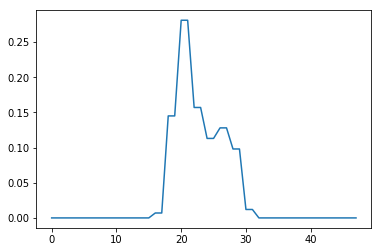

In [43]:
# matplotlib
plt.plot(sample_data)

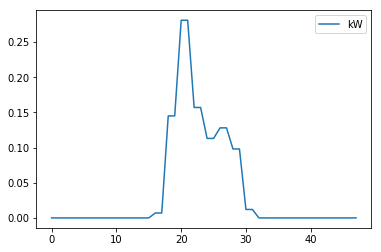

In [44]:
# pandas
sample_data.plot()

# EPG's Energy Management Framework

Has 3 modules
- Assets
- Market
- Energy System

In [45]:
import Assets as AS
import EnergySystem as ES      
import Market as MK

In [46]:
class pvAsset():
    """
    PV asset class
    
    Input
    -----
    Capacity : float
        PV capacity, kW.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.asset_type = 'PV'
        super().__init__()
        
    def getOutput(self, dt):
        """
        Return PV output
        
        Input
        -----
        dt : float
            Time interval (hours)
            
        Returns
        -------
        PV output : numpy array
        """
        df = pd.read_csv('data/solar02Jan.csv', usecols=[0])
        solar = df.values
        output = solar * self.capacity * dt
        self.output = output
        return output

# Exercise - Load solar data

In [47]:
pv_capacity = 3 # kW
pv_site1 = AS.pvAsset(pv_capacity)
solar_profile = pv_site1.getOutput(dt)
print(solar_profile[:5])

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


# Loading data - Energy System

In [48]:
nHouses = 1
dt = 30/60 # duration of individual period (h)
load_site1 = AS.loadAsset(nHouses)
load_profile = load_site1.getOutput(dt)
print(load_profile[:5])

[[0.165]
 [0.14 ]
 [0.125]
 [0.115]
 [0.11 ]]


# Plotting demand data

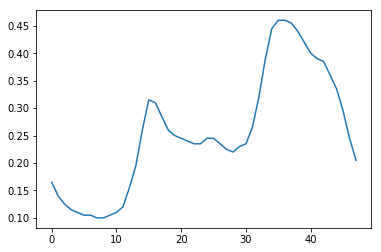

In [49]:
plt.plot(load_profile)

# Exercise - plot solar data

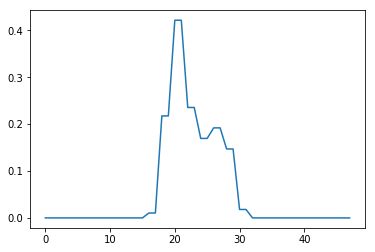

In [50]:
plt.plot(solar_profile)

# Exercise - calculate and plot nondispatchable net load

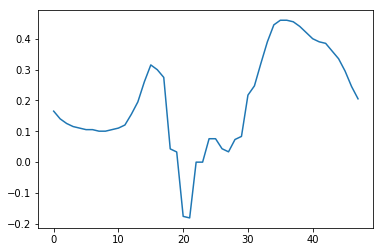

In [51]:
nondispatchable = load_profile - solar_profile
plt.plot(nondispatchable)

# Code for an ideal battery

In [52]:
energy_capacity = 2.5 #kWh
power_capacity = 1.0 #kW
T = len(nondispatchable)
outputi = np.zeros((T,1))
soc = np.zeros((T,1))
for j in range(T):
    if j == 0:
        socval = energy_capacity
    else:
        socval = soc[j-1]

    if nondispatchable[j] > 0: # use battery
        outputi[j] = min(power_capacity, nondispatchable[j], socval)
        soc[j] = socval - outputi[j]
    elif nondispatchable[j] < 0: # charge battery
        outputi[j] = max(-power_capacity, nondispatchable[j],
              -(energy_capacity - socval))
        soc[j] = socval - outputi[j]
    elif nondispatchable[j] == 0: # do nothing
        soc[j] = socval

# Code for practical battery

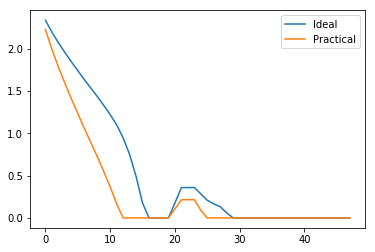

In [53]:
energy_capacity = 2.5 #kWh
power_capacity = 1.0 #kW
eff = 0.6
T = len(nondispatchable)
outpute = np.zeros((T,1))
soce = np.zeros((T,1))
for j in range(T):
    if j == 0:
        socval = energy_capacity
    else:
        socval = soce[j-1]

    if nondispatchable[j] > 0: # use battery
        outpute[j] = min(power_capacity, nondispatchable[j], eff*socval)
        soce[j] = socval - (1/eff)*outpute[j]
    elif nondispatchable[j] < 0: # charge battery
        outpute[j] = max(-power_capacity, nondispatchable[j],
              -(1/eff)*(energy_capacity - socval))
        soce[j] = socval - eff*outpute[j]
    elif nondispatchable[j] == 0: # do nothing
        soce[j] = socval

ax = plt.subplot(1,1,1)
plt.plot(soc, label='Ideal')
plt.plot(soce, label='Practical')
ax.legend()

# Operation with ideal battery

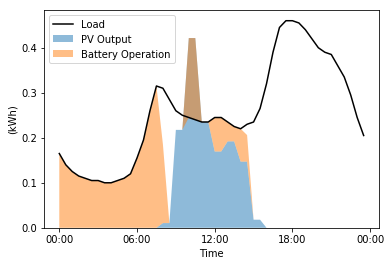

In [54]:
labels = ['PV Output', 'Battery Operation']
ax = plt.subplot(1,1,1)
p1 = plt.stackplot(np.arange(48), solar_profile.T, outputi.T, labels=labels, alpha=0.5)
p2 = plt.plot(load_profile, '-k', label='Load')
plt.xticks([0,12,24,36,48])
ax.set_xticklabels(['00:00','06:00','12:00','18:00','00:00'])
plt.ylabel('(kWh)', color='k')
plt.xlabel('Time', color='k')
ax.legend()

# Operation with practical battery

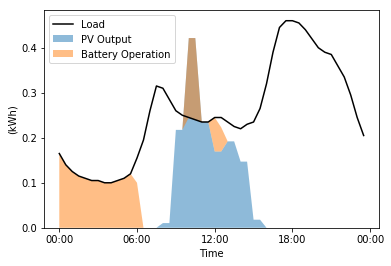

In [55]:
labels = ['PV Output', 'Battery Operation']
ax = plt.subplot(1,1,1)
p1 = plt.stackplot(np.arange(48), solar_profile.T, outpute.T, labels=labels, alpha=0.5)
p2 = plt.plot(load_profile, '-k', label='Load')
plt.xticks([0,12,24,36,48])
ax.set_xticklabels(['00:00','06:00','12:00','18:00','00:00'])
plt.ylabel('(kWh)', color='k')
plt.xlabel('Time', color='k')
ax.legend()

# Net load

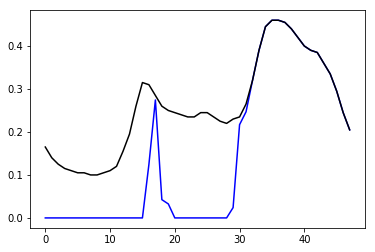

In [56]:
net_loade = nondispatchable-outpute
net_loadi = nondispatchable-outputi
plt.plot(net_loadi, 'b')
plt.plot(load_profile, 'k')

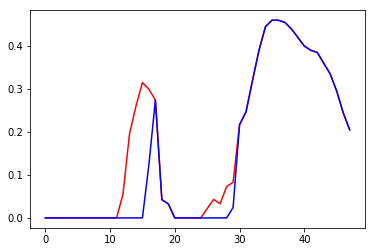

In [57]:
plt.plot(net_loade, 'r')
plt.plot(net_loadi, 'b')

# Market

In [ ]:
# setup
market1 = MK.marketObject()
# run
opCosti = market1.getOpCost(nondispatchable-outputi)
print('Operating cost with an ideal battery: £ %3.3f'%(opCosti/100))
opCoste = market1.getOpCost(nondispatchable-outpute)
print('Operating cost with an practical battery: £ %3.3f'%(opCoste/100))

# Next...
- Basic control model for generation/demand/storage assets for your project. Daily resolution for a year.
- Energy balance analysis
- Integrated market model